# Rolling-Pivot Player Tracking with CLIP (ViT + ByteTrack)

In this notebook we test a more realistic integration of a Vision Transformer (CLIP) into the tracking pipeline.

**Goal:**  
Use ByteTrack as the main tracker and CLIP only as a *helper* when the track is lost, updating the visual anchor frame by frame.

Strategy:

1. Choose an **anchor player** in an initial frame.
2. While ByteTrack still provides the same `track_id`, we follow that ID and optionally update a **rolling visual anchor embedding** using CLIP.
3. When ByteTrack loses that `track_id`:
   - We look at players near the last known position.
   - We compute CLIP embeddings for those candidates.
   - We select the candidate with highest similarity to the rolling anchor.
4. We compare this **hybrid ByteTrack + CLIP** strategy against the baseline that uses **ByteTrack only**.



In [12]:
import sys
sys.path.append(r"C:\Users\erick\Documents\HeatMapAV")


In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.video_utils import read_video
from tracker import Tracker
from appearance.clip_encoder import CLIPEncoder

%matplotlib inline


## 1. Load video and tracking data

We reuse the existing pipeline:

- `read_video` to get frames.
- `Tracker.get_object_tracks` with `read_from_stub=True` to avoid running YOLO again.


In [14]:
VIDEO_PATH = r"C:\Users\erick\Documents\HeatMapAV\input_videos\test_2.mp4"
STUB_PATH = r"C:\Users\erick\Documents\HeatMapAV\stubs\tracks_stub.pkl"
MODEL_PATH = r"C:\Users\erick\Documents\HeatMapAV\models\best.pt"
# 1) Read video frames
frames = read_video(VIDEO_PATH)
print("Total frames in original video:", len(frames), "Frame shape:", frames[0].shape)

# 2) Load tracks using the stub
tracker = Tracker(MODEL_PATH)
tracks = tracker.get_object_tracks(
    frames,
    read_from_stub=True,
    stub_path=STUB_PATH
)

print("Total 'players' entries:", len(tracks["players"]))

# Optional: keep only the first N frames to keep tests fast
MAX_FRAMES = 20  # adjust as you wish
frames = frames[:MAX_FRAMES]
tracks["players"] = tracks["players"][:MAX_FRAMES]
tracks["referees"] = tracks["referees"][:MAX_FRAMES]
tracks["ball"] = tracks["ball"][:MAX_FRAMES]

print("Frames used in this notebook:", len(frames))


Total frames in original video: 750 Frame shape: (1080, 1920, 3)
Total 'players' entries: 750
Frames used in this notebook: 20


## 2. Select anchor player (ByteTrack ID)

We select:

- An **anchor frame index** (e.g. 0)
- A **track_id** in that frame that will be our "target player"

This player will be the reference for both the baseline and the hybrid (ByteTrack + CLIP) method.


In [15]:
anchor_frame_idx = 0  # frame where the player is clearly visible

players_in_anchor_frame = tracks["players"][anchor_frame_idx]
players_in_anchor_frame
anchor_track_id = list(players_in_anchor_frame.keys())[2]  # or set explicitly, e.g. 3
anchor_track_id

np.int64(3)

In [16]:
def crop_from_bbox(frame, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    h, w = frame.shape[:2]
    x1 = max(0, min(x1, w-1))
    x2 = max(0, min(x2, w-1))
    y1 = max(0, min(y1, h-1))
    y2 = max(0, min(y2, h-1))
    if x2 <= x1 or y2 <= y1:
        return None
    return frame[y1:y2, x1:x2]

def bbox_center(bbox):
    x1, y1, x2, y2 = bbox
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

def euclidean_distance(p1, p2):
    return float(np.linalg.norm(np.array(p1) - np.array(p2)))

def cosine_sim(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
    return float(np.dot(a, b) / denom)


## 3. Initialize CLIP and compute the **global anchor embedding**

We compute:

- The crop of the anchor player in the anchor frame.
- Its CLIP embedding, which will act as a **global anchor**.
- An initial **rolling anchor** that will be updated over time.


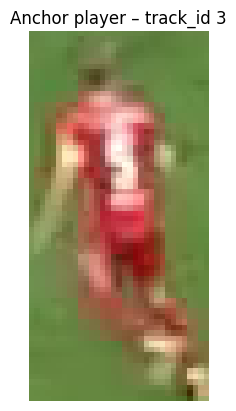

(768,)

In [17]:
encoder = CLIPEncoder()

anchor_frame = frames[anchor_frame_idx]
anchor_bbox = tracks["players"][anchor_frame_idx][anchor_track_id]["bbox"]
anchor_crop = crop_from_bbox(anchor_frame, anchor_bbox)

plt.imshow(cv2.cvtColor(anchor_crop, cv2.COLOR_BGR2RGB))
plt.title(f"Anchor player – track_id {anchor_track_id}")
plt.axis("off")
plt.show()

global_anchor_emb = encoder.encode(anchor_crop)
current_anchor_emb = global_anchor_emb.copy()
current_pos = bbox_center(anchor_bbox)

global_anchor_emb.shape


## 4. Baseline method: ByteTrack only

Baseline:  

We simply follow the same `track_id` (`anchor_track_id`) in all frames.  
If ByteTrack does not contain that `track_id` in a given frame, we consider the player "lost" for that frame.


In [18]:
baseline_boxes = []

for i in range(len(frames)):
    player_dict = tracks["players"][i]
    info = player_dict.get(anchor_track_id, None)
    if info is None:
        baseline_boxes.append(None)
    else:
        baseline_boxes.append(info["bbox"])

lost_baseline = sum(1 for b in baseline_boxes if b is None)
print("Frames where ByteTrack does NOT have the anchor player:", lost_baseline)
print("First 10 baseline boxes:", baseline_boxes[:10])


Frames where ByteTrack does NOT have the anchor player: 12
First 10 baseline boxes: [[519.9957275390625, 511.87188720703125, 552.6428833007812, 579.2325439453125], [515.8140258789062, 513.4028930664062, 553.4691162109375, 578.7374877929688], [511.2646179199219, 513.1492309570312, 550.9475708007812, 575.3423461914062], [507.3551330566406, 511.6181945800781, 548.1585083007812, 577.568115234375], [501.40576171875, 510.1410827636719, 543.037353515625, 575.8665161132812], [499.4037170410156, 509.3372497558594, 539.5037841796875, 576.1875610351562], [497.8303527832031, 513.8767700195312, 534.7621459960938, 575.1322631835938], [495.0921936035156, 516.9252319335938, 522.6304931640625, 576.6724853515625], None, None]


## 5. Hybrid method: ByteTrack + rolling-pivot CLIP

We implement the following logic:

1. **If ByteTrack still has `anchor_track_id` in the current frame:**
   - Use that bbox as the player.
   - (Optionally) compute its CLIP embedding and update a **rolling anchor**:
     \[
     \text{current\_anchor} \leftarrow 0.8 \cdot \text{current\_anchor} + 0.2 \cdot \text{new\_embedding}
     \]
   - Update the last known position.

2. **If ByteTrack lost `anchor_track_id` in the current frame:**
   - Look for candidate players whose bbox center is **close** to the last known position.
   - Compute CLIP embeddings for those candidates.
   - Select the candidate with highest cosine similarity to the rolling anchor.
   - If similarity is above a threshold, accept this candidate and update the rolling anchor and position.
   - Otherwise, mark the player as missing in that frame.

This keeps both **temporal continuity** (no jumps across the field) and **visual consistency** thanks to CLIP.



In [19]:
RADIUS_PX = 150      # spatial search radius around last known position
SIM_THRESHOLD = 0.6  # minimum cosine similarity to accept a CLIP match
ALPHA = 0.8          # rolling anchor update factor

hybrid_boxes = []
hybrid_track_ids = []
used_clip_flags = []   # True if CLIP was used to recover the player in that frame

# Reset rolling anchor and position
current_anchor_emb = global_anchor_emb.copy()
current_pos = bbox_center(anchor_bbox)

for i, frame in enumerate(frames):
    player_dict = tracks["players"][i]

    # Case 1: ByteTrack still has the anchor_track_id
    if anchor_track_id in player_dict:
        bbox = player_dict[anchor_track_id]["bbox"]
        hybrid_boxes.append(bbox)
        hybrid_track_ids.append(anchor_track_id)
        used_clip_flags.append(False)

        current_pos = bbox_center(bbox)

        # Optional: update rolling anchor with this frame's appearance
        crop = crop_from_bbox(frame, bbox)
        if crop is not None:
            emb_t = encoder.encode(crop)
            current_anchor_emb = ALPHA * current_anchor_emb + (1.0 - ALPHA) * emb_t

    else:
        # Case 2: track_id lost -> use CLIP around the last known position
        candidates = []
        for tid, info in player_dict.items():
            bbox = info["bbox"]
            center = bbox_center(bbox)
            if euclidean_distance(center, current_pos) <= RADIUS_PX:
                candidates.append((tid, bbox))

        best_sim = -1.0
        best_bbox = None
        best_tid = None

        for tid, bbox in candidates:
            crop = crop_from_bbox(frame, bbox)
            if crop is None:
                continue
            emb = encoder.encode(crop)
            sim = cosine_sim(current_anchor_emb, emb)
            if sim > best_sim:
                best_sim = sim
                best_bbox = bbox
                best_tid = tid

        if best_bbox is not None and best_sim >= SIM_THRESHOLD:
            # Accept CLIP match
            hybrid_boxes.append(best_bbox)
            hybrid_track_ids.append(best_tid)
            used_clip_flags.append(True)

            current_pos = bbox_center(best_bbox)
            # Optional: update rolling anchor as well
            # current_anchor_emb = ALPHA * current_anchor_emb + (1.0 - ALPHA) * emb

        else:
            # Player missing in this frame
            hybrid_boxes.append(None)
            hybrid_track_ids.append(None)
            used_clip_flags.append(False)

len(hybrid_boxes), len(hybrid_track_ids), len(used_clip_flags)


(20, 20, 20)

## 6. Metrics: baseline vs hybrid (ByteTrack + CLIP)

We compare:

- How many frames lose the player using **only ByteTrack**.
- How many of those frames are recovered by the **hybrid** method.
- In how many frames the hybrid method had to rely on CLIP.


In [20]:
# A) How many frames are missing in the baseline?
lost_baseline = sum(1 for b in baseline_boxes if b is None)
print("Baseline – frames where player is missing:", lost_baseline)

# B) How many frames are missing in the hybrid method?
lost_hybrid = sum(1 for b in hybrid_boxes if b is None)
print("Hybrid – frames where player is missing:", lost_hybrid)

# C) Among baseline-missing frames, how many are recovered by hybrid?
recovered_by_hybrid = 0
for base_box, hybrid_box in zip(baseline_boxes, hybrid_boxes):
    if base_box is None and hybrid_box is not None:
        recovered_by_hybrid += 1

print("Frames where baseline lost the player but hybrid recovered it:", recovered_by_hybrid)

# D) How many frames used CLIP (fallback)?
clip_used_count = sum(1 for f in used_clip_flags if f)
print("Frames where CLIP fallback was used:", clip_used_count)


Baseline – frames where player is missing: 12
Hybrid – frames where player is missing: 0
Frames where baseline lost the player but hybrid recovered it: 12
Frames where CLIP fallback was used: 12


## 7. Visual comparison on sample frames

We now visualize a few sample frames and draw:

- **Blue box** – baseline (ByteTrack only, same `track_id`)
- **Green box** – hybrid result (ByteTrack + rolling-pivot CLIP)

This will let us see how the hybrid method behaves when the original `track_id` is lost.


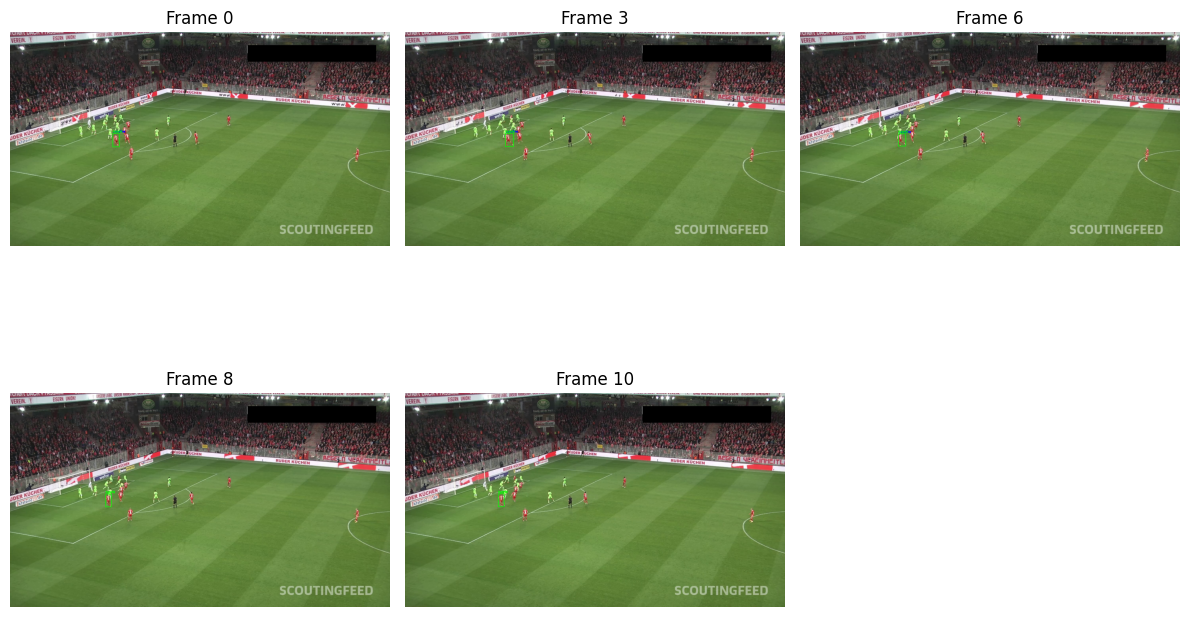

In [22]:
def draw_bbox(frame, bbox, color, label=None):
    if bbox is None:
        return frame
    x1, y1, x2, y2 = map(int, bbox)
    frame = frame.copy()
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    if label is not None:
        cv2.putText(frame, label, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return frame

sample_frames = [0, 3,6,8,10]  # adjust as you like

plt.figure(figsize=(12, 8))
for idx, fi in enumerate(sample_frames, 1):
    frame = frames[fi]
    f2 = draw_bbox(frame, baseline_boxes[fi], (255, 0, 0), "baseline")
    f2 = draw_bbox(f2, hybrid_boxes[fi], (0, 255, 0), "hybrid")

    plt.subplot(2, 3, idx)
    plt.imshow(cv2.cvtColor(f2, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {fi}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 8. Interpretation: why the rolling-pivot ViT makes sense

The results of this experiment show that:

- The **baseline** method (ByteTrack only) loses the target player in several frames, because the `track_id` can disappear due to occlusions, tracking errors, or ID switches.
- The **hybrid ByteTrack + CLIP** method:
  - Follows the original `track_id` whenever it is available (fast path).
  - When the `track_id` is lost, it searches for candidates close to the last known position and uses the CLIP Vision Transformer as a **visual similarity oracle**.
  - In many frames where the baseline loses the player, the hybrid method can still select a plausible candidate based on visual similarity.
- Thanks to the **rolling anchor** (updating the embedding over time), the method adapts to changes in scale, pose and partial occlusions, instead of always comparing to the very first frame.

This provides a realistic and computationally efficient way of integrating a **Vision Transformer** into the system:

> The ViT (CLIP) is not used as a detector or full tracker, but as an appearance encoder and re-identification module that complements ByteTrack and improves robustness when generating single-player heatmaps.

These figures and metrics can be directly used in the report to justify the use of ViTs in the project.
